# Deep Residual Learning for Image Recognition

Notebook written by Shuang HOU

At the end of 2015, Microsoft Research Asia released a paper titled ["Deep Residual Learning for Image Recognition" [1]](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf), authored by Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun. The paper achieved state-of-the-art results in Image classification and detection, winning the ImageNet and COCO competitions. This notebook is a PyTorch implementation of the Deep Residual Neural Networks (**ResNet** for short) based on this paper.

This notebook is prepared for students who have participated in the AML course (or a fairly close course). It supposes a basic knowledge of Deep Learning and Convolutional Neural Networks, which have been introduced in the previous courses ([DL](https://github.com/SupaeroDataScience/deep-learning/tree/main/deep), [CNN](https://github.com/fchouteau/isae-practical-deep-learning)), you can refer to them if needed.

If you encounter any problems in the process of running this notebook, please feel free to contact me, I will help you solve the problem together.

**Table of contents:**
0. [Preparation](#sec0)
1. [Dataset: Fashion-MNIST](#sec1)
2. [Problem introduction](#sec2)
3. [Construction of Residual Networks](#sec3)
4. [Experiments](#sec4)
5. [Conclusion](#sec5)

# <a id="sec0"></a>0. Preparation

In this notebook, we'll be using `torch` and `torchvision`, which we have already used in previous AML courses. Run the following code cells to install the necessary packages and verify that everything is working by importing everything. If it doesn't work, check the `requirements.txt` file and install the libraries manually using either `pip install` or `conda install`.

Please refer to the [PyTorch](https://pytorch.org/get-started/locally/) website for installation instructions if necessary. We'll also be using packages `sklearn`, `numpy`, and `matplotlib`. 

<div class="alert alert-danger">

Note that this notebook is fairly compute intensive and it might be better to **[run in Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true).**
    
If you use Colab, mind yourself to **add external folders** (especially solutions and img) to it, the data folder is not necessary to be added, because the data can be downloaded by running the code cell in part 1 Dataset. Then change alter default hardware CPU to **GPU**: just follow `Edit` > `Notebook settings` or `Runtime` > `Change runtime type` and select `GPU` as Hardware accelerator.
       
</div>

<img src="img/runtime.png" width="35%"></img>

In [1]:
# !pip install -r requirements.txt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as Data
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time

In [3]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101


# <a id="sec1"></a>1. Dataset: Fashion-MNIST

[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28 $\times$ 28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits but is more complex.

<img src="img/fashion-mnist-small.png"></img>

In [4]:
labels_text = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

PyTorch comes with this dataset by default, but we need to download it. We'll then make dataloaders which lazily iterate through the datasets. We'll use a training set and a validation set and greatly reduce their sizes to make this notebook run in a reasonable time.

In [5]:
# Hyperparameter for DataLoader
BATH_SIZE = 512

In [6]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

full_trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
trainset, full_validset = torch.utils.data.random_split(full_trainset, (10000, 50000))
validset, _ = torch.utils.data.random_split(full_validset, (1000, 49000))
testset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATH_SIZE, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATH_SIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATH_SIZE, shuffle=True, num_workers=2)

In [7]:
# Checking the dataset
for images, labels in trainloader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([512, 1, 28, 28])
Image label dimensions: torch.Size([512])


# <a id="sec2"></a>2. Problem introduction

From experience, the depth of the network is crucial to the performance of the model. When the number of network layers is increased (increasing the depth), the network can extract more complex feature patterns, so theoretically, better results can be obtained when the model is deeper.

But... Is learning better networks as easy as stacking more layers?

Of course not! Deep network optimization is very difficult, and there will be many problems occurring, such as the notorious problem of [vanishing/exploding gradients [2]](https://ieeexplore-ieee-org.rev-doc.isae.fr/stamp/stamp.jsp?tp=&arnumber=279181). While these problems has been almost solved by methods such as [Normalized Initialization [3]](https://arxiv.org/pdf/1502.01852.pdf) and [Batch Normalization [4]](https://arxiv.org/pdf/1502.03167.pdf).

However, experiments have found that when deeper networks are able to start converging, a degradation problem has been exposed. In other words, with the network depth increasing, accuracy gets saturated (which might be unsurprising) and then degrades rapidly. This phenomenon can be seen directly in Figure 1 from [paper[1]](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf) which shows the training error (left) and test error (right) on CIFAR-10 with 20-layer and 56-layer "plain" networks. The deeper network has higher training error, and thus the same for test error. This is not caused by overfitting, because the training error (left) of the 56-layer network is also higher than that of the 20-layer.

<img src="img/degradation.JPG" width="60%"></img>

<center><font size=1.5><br>Figure 1. Training error (left) and test error (right) on CIFAR-10 with 20-layer and 56-layer "plain" networks.<br>
    The deeper network has higher training error, and thus test error.</font></center>

<div class="alert alert-warning">

**Let's think about this question:**<br>

What caused the deeper network degradation problem?

How to effectively solve the "degradation" problem caused by the increase in network depth?
    
</div>

<div class="alert alert-info"><a href="#answer1" data-toggle="collapse"><b>Ready to see the answer? (click to expand)</b></a><br>
<div id="answer1" class="collapse">

The problem of degradation is mainly due to the increase in network depth. During model training, the gradient cannot be effectively transmitted to the shallow network, resulting in vanishing/exploding gradients. Batch Normalization (BN) changes the data distribution by normalizing the output data, which is a forward process to solve the vanishing/exploding gradients problem. 
    
For the degradation problem, instead of directly fitting a desired underlying mapping, it is better to make the network fitting a residual mapping. Here comes the Residual Network (ResNet)! ResNet directly connects the shallow network and the deep network by adding **shortcut connection** (Identity Map), so that the gradient can be well transmitted to the shallow layer.
    
</div>
</div>

# <a id="sec3"></a>3. Construction of Residual Networks

### <a id="sec3-1"></a>3.1. Residual representation & shortcut connections

In response to the "degradation" problem, Kaiming He proposed a **deep residual learning framework**, which uses a multi-layer network to fit a residual mapping.

Formally, denoting the desired underlying mapping as $H(x)$, we let the stacked nonlinear layers fit another mapping:

$$F(x) := H(x)−x$$ 

The original mapping is recast into:

$$F(x)+x$$. 

The formulation of $F(x)+x$ can be realized by feedforward neural networks with "**shortcut connections**". Shortcut connections are those skipping one or more layers. For the case in [paper [1]](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf), the shortcut connections simply perform identity mapping, and their outputs are added to the outputs of the stacked layers. 

Figure 2 shows a 2-layer basic building block of residual learning in the deep residual networks:

<img src="img/2-layer building block.JPG" width="400px"></img>

<center><font size=1.5><br>Figure 2. Residual learning: a building block.</font></center>

Why is easier to optimize the residual mapping than to optimize the original, unreferenced mapping?

Formally, such a basic building block of ResNet can be expressed as:

$$y_l = F(x_l,W_{l}) + x_l$$

$$x_{l+1} = f(x_l)$$

Where:

- $x_l$ represents the input vector of the l-th residual block.
- $x_{l+1}$ represents the output vector of the l-th residual block.
- $F(x, W_l)$ represents the residual mapping to be learned, which is the superposition of multiple nonlinear convolutional layers.<br>
  For the example in Figure 2 that has two layers, $F = W_2 \sigma(W_1 x)$ in which $\sigma$ represents the nonlinear activation function ReLU, and the biases are omitted for simplifying notations.
- $F+x$ means shortcut connection, which corresponds to the addition of each pixel.
- $f$ is an activation function.

Then the learning representation from shallow to deep layer can be calculated as:

$$X_L = x_l + \sum_{i=l}^{L-1} F(x_i,W_{i}) $$

According to the chain rule, the gradient of back propagation is:

$$\frac{\partial loss}{\partial x_l} = \frac{\partial loss}{\partial x_L} · \frac{\partial x_L}{\partial x_l} = \frac{\partial loss}{\partial x_L} · \left( 1+ \frac{\partial}{\partial x_L}\sum_{i=l}^{L-1} F(x_i,W_{i}) \right)$$

The $1$ in the parentheses indicates that the shortcut connection can spread the gradient without loss, and the other item (residual gradient) needs to pass through the layer with weights, thsu the gradient is not directly transferred. The residual gradient will not be so coincidentally that all are equal to -1, and even if it is relatively small, the existence of $1$ in the parentheses will not cause the gradient to disappear. So the residual learning will be easier than the original, unreferenced mapping.

<div class="alert alert-info">

**In brief:**<br>
- If identity mappings are added, a deeper network will not perform worse than a shallow network.
- It is difficult to learn identify mapings in a network structure composed of multiple non-linear layers.
- If identity mapings is the optimal link method, then the weight parameters of $F(x)$ will tend to $0$.
- If the optimal mapping is close to identity mappings, it is much easier to find the $F(x)$ corresponding to the identity mappings (initial parameters near 0) during optimization than to approximately fit a completely new function.
    
</div>

<div class="alert alert-warning">
    
**Note 1:**<br>
    
Identity shortcut connections add neither extra parameter nor computational complexity. The entire network can still be trained end-to-end by SGD with backpropagation, and can be easily implemented using common libraries (e.g., [Caffe [5]](https://arxiv.org/pdf/1408.5093.pdf)) without modifying the solvers.

</div>
    
<div class="alert alert-warning">

**Note 2:**<br>
    
In the expression above $y_l = F(x_l,W_{l}) + x_l$, the dimensions of $x_l$ and $F$ must be equal. If this is not the case (e.g., when changing the input/output channels), we can perform a linear projection $W_s$ by the shortcut connections to match the dimensions, which can be implemented with a convolutional layer in programming:

$$y_l = F(x_l, W_l) + W_{s}x_l$$

The meaning of the parameters in this formula is the same as before. 
    
</div>

### <a id="sec3-2"></a>3.2. Basic building block

A basic 2-layer building block is consist of the following parts sequentially, as shown in Figure 3:

- a first 3$\times$3 convolution
- a Batch Normalization 
- ReLU activation
- a second 3$\times$3 convolution
- a Batch Normalization 
- Addition of the shortcut connection
- ReLU activation

<img src="img/basic-building-block.png" width="200px"></img>

<center><font size=1.5><br>Figure 3. The specific composition of the 2-layer basic building block</font></center>

Now we come to implement this building block in programming:

In [8]:
def conv3x3(in_channel, out_channel, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_channel, out_channel, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [9]:
class BasicBlock(nn.Module):
    
    """
    Basic building block for ResNet-18/34.
    
    Args：
        - in_channel: Number of input channel
        - out_channel: Number of output channel
        - stride: Number of stride 
        - downsample: "None" for identity downsample, otherwise for a real downsample
    
    """
    
    expansion = 1    # Record whether the number of convolution kernels in each layer has changed
    
    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_channel, out_channel, stride)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channel, out_channel)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x    # Record the output of the last residual block

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:    # Determine if need to downsample for dimension matching
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

### <a id="sec3-3"></a>3.3. Deeper bottleneck building block

In terms of $F(x_l, W_l)$, it should not be limited to the 2-layer convolution connection mentioned above, it can be more diverse, 3 layers, or even more; but not 1 layer, because the performance of 1-layer will be unsatisfactory.

A 3-layer building block is shown on the right of Figure 4, which called a **bottleneck** building block, and is used to build the ResNet-50/101/152.

<img src="img/3-layer building block.JPG"></img>

<center><font size=1.5><br>Figure 4. Two different building blocks for residual learning.<br> 
    Left: a building block (on 56 $\times$ 56 feature maps) as in Figure 6 for ResNet-34.<br>
    Right: a "bottleneck" building block for ResNet-50/101/152.</font></center>
    
The purpose of such a bottleneck building block is to reduce the number of parameters. The first 1$\times$1 convolution reduces the 256-dimensional channel to 64-dimensional, and then it is restored by 1$\times$1 convolution at the end.

The total number of parameters used in the bottleneck building block is: 

$$1\times1\times256\times64 + 3\times3\times64\times64 + 1\times1\times64\times256 = 69632$$

Without bottleneck, it is a convolution of two 3x3x256, the number of parameters is: 

$$3\times3\times256\times256\times2 = 1179648$$

which is $16.94$ times the difference.

The bottleneck building blocks used for ResNet-50/101/152 is shown in the Figure 5 below, composed of an identity block (skip connection) skipping over 3 layers, and a convolutional block used to adjust the dimensions.

<img src="img/resnet50-identity-block.png" width="70%"></img>

<img src="img/resnet50-conv-block.png" width="70%"></img>

<center><font size=1.5><br>Figure 5. The bottleneck building blocks of ResNet-50/101/152</font></center>

Now we come to implement this bottleneck building block in programming:

In [10]:
def conv3x3(in_channel, out_channel, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_channel, out_channel, kernel_size=3,
                     stride=stride, padding=1, bias=False)

def conv1x1(in_channel, out_channel, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride, bias=False)

In [11]:
class Bottleneck(nn.Module):
    """
    Bottleneck building block for ResNet-50/101/152.
    
    Args：
        - in_channel: Number of input channel
        - out_channel: Number of output channel
        - stride: Number of stride 
        - downsample: "None" for identity downsample, otherwise for a real downsample
    
    """

    expansion = 4       # The number of convolution kernels in the third layer (256, 512, 1024, 2048) 
                        # is 4 times the number of convolution kernels in the first or second layer (64, 128, 256, 512)

    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(in_channel, out_channel)           # Squeeze channels for dimensionality reduce
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = conv3x3(out_channel, out_channel, stride)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.conv3 = conv1x1(out_channel, out_channel * self.expansion)   # Unsqueeze channels for dimensionality increase
        self.bn3 = nn.BatchNorm2d(out_channel * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

### <a id="sec3-3"></a>3.3. Complete network architectures

On the right of the Figure 6 is a overall residual network with 34 parameter layers (ResNet-34). The dotted shortcuts increase dimensions. <br>
Table 1 shows more details and other variants.

<img src="img/plain-res nets.jpg" width="55%"></img>

<center><font size=1.5><br>Figure 6. Example network architectures for ImageNet.<br>
    Left: the [VGG-19] model(19.6 billion FLOPs) as a reference.<br> 
    Middle: a plain network with 34 parameter layers (3.6 billion FLOPs).<br>
    Right: a residual network with 34 parameter layers (3.6 billionFLOPs).<br>
    The dotted shortcuts increase dimensions.</font></center>

<center><font size=1.5><br>Table 1. Architectures for ResNet-18/34 and ResNet-50/101/152.<br>
    Building blocks are shown in brackets, with the numbers of blocks stacked.<br>
    Downsampling is performed by conv3, conv4, and conv5 with a stride of 2.</font></center>
    
<img src="img/ResNet-architecture.JPG" width="80%"></img>

The building blocks of the same color can be considered as a large color-layer of the whole ResNet. For example, for the ResNet-34 and ResNet-50, the number of residual blocks in each color-layer are both: [3, 4, 6, 3] according to Table 1.

Therefore, for **ResNet-34**, it is sequentially consist of:

- conv1: a 3 x 3 convolution (+ maxpool)
- conv2: **3** basic building block, output size = 56 x 56
- conv3: **4** basic building block, output size = 28 x 28
- conv4: **6** basic building block, output size = 14 x 14
- conv5: **3** basic building block, output size = 7 x 7
- avgpool + fc: output size = 1 x 1

For ResNet-34, the number of layers of each residual block is **[3, 4, 6, 3]**.

The total number of layers of ResNet-34 is: $1 + 2\times(3+4+6+3) + 1 = 34$, so called ResNet-34.

Similar for **ResNet-50**, except changing the 2-layer basic building block to a 3-layer bottleneck building block:

- conv1: a 3 x 3 convolution (+ maxpool)
- conv2: **3** bottleneck building block, output size = 56 x 56
- conv3: **4** bottleneck building block, output size = 28 x 28
- conv4: **6** bottleneck building block, output size = 14 x 14
- conv5: **3** bottleneck building block, output size = 7 x 7
- avgpool + fc: output size = 1 x 1

For ResNet-50, the number of layers of each residual block is the same as ResNet-34 : **[3, 4, 6, 3]**.

The total number of layers of ResNet-50 is: $1 + 3\times(3+4+6+3) + 1 = 50$, so called ResNet-50.

**ResNet-101** has the same bettleneck building block as ResNet-50, but with a different layer numbers.

- conv1: a 3 x 3 convolution (+ maxpool)
- conv2: **3** bottleneck building block, output size = 56 x 56
- conv3: **4** bottleneck building block, output size = 28 x 28
- conv4: **23** bottleneck building block, output size = 14 x 14
- conv5: **3** bottleneck building block, output size = 7 x 7
- avgpool + fc: output size = 1 x 1

For ResNet-101, the number of layers of each residual block is **[3, 4, 23, 3]**.

The total number of layers of ResNet-101 is: $1 + 3\times(3+4+23+3) + 1 = 101$, so called ResNet-101.

Now that we have previously defined the two different building blocks, let's implement the complete residual networks!

In [12]:
class ResNet(nn.Module):
    """
    Implementation of ResNet architecture.
    
    Arg：
        - block: "BasicBlock" for ResNet-18/34, "Bottleneck" for ResNet-50/101/152
        - layers: The number of each residual layer, for example, [3,4,6,3] for the ResNet-34/50
        - num_classes: The number of labels in the data set
        - grayscale: "True" for single-channel images, "False" for 3-channel images

    """

    def __init__(self, block, layers, num_classes, grayscale):
        self.in_channel = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        
        #  conv1 + maxpooling
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #  conv2,3,4,5
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        #  avgpooling + fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        #  Initialization of the convolutional layer
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, out_channel, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != out_channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, out_channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channel * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channel, out_channel, stride, downsample))
        self.in_channel = out_channel * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_channel, out_channel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [13]:
def resnet34(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    net = ResNet(block = BasicBlock,
                 layers = [3, 4, 6, 3],
                 num_classes = num_classes,
                 grayscale = grayscale)
    return net

In [14]:
def resnet50(num_classes, grayscale):
    """Constructs a ResNet-50 model."""
    net = ResNet(block = Bottleneck,
                 layers = [3, 4, 6, 3],
                 num_classes = num_classes,
                 grayscale = grayscale)
    return net

<div class="alert alert-success">

**Now it's your turn!**
<br>    
Exercise 1: Known that **ResNet-18** has the same basic building block as ResNet-34, but for ResNet-18, the number of color-layers of each block is: **[2, 2, 2, 2]**, try to construct a function for resnet18.
    
</div>

In [15]:
# %load solutions/resnet18.py
def resnet18(num_classes, grayscale):
    """Constructs a ResNet-18 model."""
    ### WRITE YOUR CODE HERE
    return net

<div class="alert alert-success">

Exercise 2: **ResNet-101** has the same bottleneck building block as ResNet-50, but for ResNet-101, the number of color-layers is: **[3, 4, 23, 3]**, try to construct a function for resnet101.
    
</div>

In [16]:
# %load solutions/resnet101.py
def resnet101(num_classes, grayscale):
    """Constructs a ResNet-101 model."""
    ### WRITE YOUR CODE HERE
    return net

<div class="alert alert-success">

Exercise 3: **ResNet-152** has the same bottleneck building block as ResNet-50, but with the number of color-layers: **[3, 8, 36, 3]**, try to construct a function for resnet152.
    
</div>

In [17]:
# %load solutions/resnet152.py
def resnet152(num_classes, grayscale):
    """Constructs a ResNet-152 model."""
    ### WRITE YOUR CODE HERE
    return net

# <a id="sec4"></a>4. Experiments

At the beginning of the experiment, there are some preparatory works to do:

- Set up the device, the GPU is preferred because the calculation is very resource-intensive.
- Setting global hyperparameters, which can be used for possible parameter tuning.
- Model instantiation, for ResNet-34, ResNet-50 and ResNet101.

In this part of experiments, we will conduct a comparative analysis of the model performance for ResNet-34, ResNet-50 and ResNet-101, because they are currently the three most commonly used residual network structures, and they have comparable meanings with each other: ResNet-34 and ResNet-50 have the same number of residual network layers [3, 4, 6, 3], ResNet-50 and ResNet-101 have the same bottleneck building blocks. We will successively experiment these three ResNet models respectively for model training, verification, and testing.

In [18]:
# Set up the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Training on {}'.format(device))

Training on cuda:0


In [19]:
# Hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 512
NUM_EPOCHS = 50

# Architecture
NUM_FEATURES = 32*32
NUM_CLASSES = 10

# Other
GRAYSCALE = True

Run the following three cells to instantiate the model ResNet-34, ResNet-50 and ResNet-101 respectively, and for each ResNet, the specific composition of each layer will be displayed for viewing.

In [20]:
net34 = resnet34(NUM_CLASSES, GRAYSCALE)
net34 = net34.to(device)
print(net34)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
net50 = resnet50(NUM_CLASSES, GRAYSCALE)
net50 = net50.to(device)
print(net50)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
net101 = resnet101(NUM_CLASSES, GRAYSCALE)
net101 = net101.to(device)
print(net101)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### <a id="sec4-1"></a>4.1.  Model training for three ResNets

`Torch` provides loss functions and optimizers that we can use instead of writing our own. For now, we'll use the `torch.nn.CrossEntropyLoss` and `torch.optim.SGD` functions. Another alternative optimizer function is `torch.optim.Adam`. If you want, you can also change the comment line of the optimizer in the following code cells to see how the result will change.

Let's first look at the loss when the model is trained for only **one epoch**. The hyperparameter `NUM_EPOCHS` has not been used in this part, and there is no loop about epoch.

In [23]:
def train(net):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    # optimizer = torch.optim.Adam(net.parameters())       # Alternative optimizer "Adam"
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss

In [24]:
%time train_loss_34 = train(net34)
print('train loss of ResNet-34 : %0.5f' % (train_loss_34))

CPU times: user 2.72 s, sys: 1.52 s, total: 4.24 s
Wall time: 4.54 s
train loss of ResNet-34 : 40.15110


In [25]:
%time train_loss_50 = train(net50)
print('train loss of ResNet-50 : %0.5f' % (train_loss_50))

CPU times: user 4.71 s, sys: 3.26 s, total: 7.97 s
Wall time: 8.3 s
train loss of ResNet-50 : 49.03495


In [26]:
%time train_loss_101 = train(net101)
print('train loss of ResNet-101 : %0.5f' % (train_loss_101))

CPU times: user 6.25 s, sys: 4.28 s, total: 10.5 s
Wall time: 10.9 s
train loss of ResNet-101 : 48.15834


From the perspective of train loss, that of a single epoch is still quite large.

To see how our network performs more preciously, we'll apply it to the validation set.

In [27]:
def get_valid_predictions(net):
    all_labels = np.array([])
    predictions = np.array([])
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels = np.append(all_labels, labels.cpu().numpy())
            predictions = np.append(predictions, predicted.cpu().numpy())
    return all_labels, predictions

In [28]:
from sklearn.metrics import accuracy_score, classification_report

In [29]:
y_valid_34, predictions_34 = get_valid_predictions(net34)

print('ResNet-34 accuracy: ', accuracy_score(predictions_34, y_valid_34))
print(classification_report(predictions_34, y_valid_34, target_names=labels_text))

ResNet-34 accuracy:  0.602
              precision    recall  f1-score   support

 T-shirt/top       0.61      0.57      0.59       112
     Trouser       0.87      0.83      0.85       109
    Pullover       0.32      0.55      0.41        67
       Dress       0.57      0.63      0.60        86
        Coat       0.59      0.41      0.49       147
      Sandal       0.57      0.49      0.53        87
       Shirt       0.28      0.32      0.30        97
     Sneaker       0.78      0.66      0.72       104
         Bag       0.62      0.84      0.71        82
  Ankle boot       0.90      0.76      0.83       109

    accuracy                           0.60      1000
   macro avg       0.61      0.61      0.60      1000
weighted avg       0.63      0.60      0.61      1000



In [30]:
y_valid_50, predictions_50 = get_valid_predictions(net50)

print('ResNet-50 accuracy: ', accuracy_score(predictions_50, y_valid_50))
print(classification_report(predictions_50, y_valid_50, target_names=labels_text))

ResNet-50 accuracy:  0.19
              precision    recall  f1-score   support

 T-shirt/top       0.13      0.16      0.15        88
     Trouser       0.30      0.21      0.24       151
    Pullover       0.13      0.22      0.16        69
       Dress       0.19      0.25      0.22        72
        Coat       0.15      0.19      0.17        85
      Sandal       0.04      0.07      0.05        45
       Shirt       0.12      0.11      0.12       114
     Sneaker       0.16      0.25      0.20        55
         Bag       0.23      0.16      0.19       160
  Ankle boot       0.43      0.25      0.32       161

    accuracy                           0.19      1000
   macro avg       0.19      0.19      0.18      1000
weighted avg       0.22      0.19      0.20      1000



In [31]:
y_valid_101, predictions_101 = get_valid_predictions(net101)

print('ResNet-101 accuracy: ', accuracy_score(predictions_101, y_valid_101))
print(classification_report(predictions_101, y_valid_101, target_names=labels_text))

ResNet-101 accuracy:  0.181
              precision    recall  f1-score   support

 T-shirt/top       0.17      0.19      0.18        95
     Trouser       0.21      0.54      0.30        41
    Pullover       0.14      0.14      0.14       117
       Dress       0.11      0.28      0.15        36
        Coat       0.15      0.18      0.16        90
      Sandal       0.37      0.18      0.24       158
       Shirt       0.20      0.16      0.18       139
     Sneaker       0.23      0.18      0.20       112
         Bag       0.13      0.16      0.15        94
  Ankle boot       0.15      0.12      0.13       118

    accuracy                           0.18      1000
   macro avg       0.19      0.21      0.18      1000
weighted avg       0.20      0.18      0.18      1000



From the perspective of ResNet model prediction accuracy, that of a single epoch for all the three ResNet models are unsatisfactory. Theoretically known that the accuracy of training results will improve as the number of training epochs increases.

Here comes a hyperparameter `NUM_EPOCHS` that we set previously, which indicates how many epochs will be trained. Its initial value is set to 50, you can try to modify the value of this hyperparameter to see how the result will change if you want. But be aware that the larger the value of `NUM_EPOCHS`, the longer the calculation will take.

Now, Let's train our model net34, net50 and net101 completely with **`NUM_EPOCHS`** times.

In [32]:
criterion = nn.CrossEntropyLoss()

def validation(net):
    valid_loss = 0
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
    return valid_loss

def train_all(net):
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    # optimizer = torch.optim.Adam(net.parameters())      # Alternative optimizer "Adam"
    train_history = []
    valid_history = []
    for epoch in range(NUM_EPOCHS):
        net.train()
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        valid_loss = validation(net)
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print('Epoch %02d: train loss %0.5f, validation loss %0.5f' % (epoch, train_loss, valid_loss))
    return train_history, valid_history

The training of the ResNet model will take a few minutes depending on the processor. For reference, running on the GPU in my laptop, with `NUM_EPOCHS`=50, ResNet-34 takes about 4 minutes,  ResNet-50 takes about 7 minutes, and ResNet-101 takes about 10 minutes. It will take longer to run on the CPU, that is why it is recommended to run this notebook in Google Colab.

Hope that it will take shorter time to run on your side, maybe you can take this opportunity to have a coffee break ;-)  But don't forget to run the following six code cells of model training before going for a coffee!

In [33]:
start = time.time()
train_history_34, valid_history_34 = train_all(net34)
end = time.time()
print(f'total time for ResNet-34: {end - start} s')

Epoch 00: train loss 106.03732, validation loss 3.64067
Epoch 01: train loss 29.96314, validation loss 2.23967
Epoch 02: train loss 19.34668, validation loss 1.82376
Epoch 03: train loss 16.69749, validation loss 1.54463
Epoch 04: train loss 13.77235, validation loss 1.37090
Epoch 05: train loss 12.58052, validation loss 1.31411
Epoch 06: train loss 11.56787, validation loss 1.21249
Epoch 07: train loss 10.83895, validation loss 1.21739
Epoch 08: train loss 10.33804, validation loss 1.10972
Epoch 09: train loss 9.75424, validation loss 1.07066
Epoch 10: train loss 9.18258, validation loss 1.09703
Epoch 11: train loss 8.62650, validation loss 1.06962
Epoch 12: train loss 8.19472, validation loss 1.04120
Epoch 13: train loss 7.75173, validation loss 0.96505
Epoch 14: train loss 7.36269, validation loss 0.96841
Epoch 15: train loss 6.71230, validation loss 0.92811
Epoch 16: train loss 6.64439, validation loss 0.94405
Epoch 17: train loss 6.43581, validation loss 1.03403
Epoch 18: train lo

In [49]:
# Save trained model for later use
model_file_34 = "models/resnet34"   
torch.save(net34, model_file_34)

<div class="alert alert-info">

If you get this error when running the code above for model saving:
    
    `FileNotFoundError: [Errno 2] No such file or directory: 'models/resnet34'`
    
Don't worry, this is for the raison that we don't have the `models` folder yet.
    
Please manually create a `models` folder at the same level as `resnet.ipynb`, and then run the code again.
    
</div>

In [36]:
start = time.time()
train_history_50, valid_history_50 = train_all(net50)
end = time.time()
print(f'total time for ResNet-50: {end - start} s')

Epoch 00: train loss 242.25215, validation loss 4.50700
Epoch 01: train loss 44.66379, validation loss 4.44224
Epoch 02: train loss 44.11992, validation loss 4.45448
Epoch 03: train loss 43.81619, validation loss 4.40447
Epoch 04: train loss 43.68646, validation loss 4.40462
Epoch 05: train loss 43.05862, validation loss 4.33753
Epoch 06: train loss 42.69764, validation loss 4.34281
Epoch 07: train loss 41.98406, validation loss 4.19080
Epoch 08: train loss 40.10318, validation loss 3.89935
Epoch 09: train loss 38.46389, validation loss 3.68492
Epoch 10: train loss 35.12775, validation loss 3.21457
Epoch 11: train loss 29.31037, validation loss 2.79990
Epoch 12: train loss 25.43008, validation loss 2.50542
Epoch 13: train loss 22.94154, validation loss 2.33957
Epoch 14: train loss 21.14796, validation loss 2.14664
Epoch 15: train loss 19.85869, validation loss 2.39080
Epoch 16: train loss 19.17495, validation loss 1.87019
Epoch 17: train loss 18.31631, validation loss 1.95705
Epoch 18:

In [50]:
model_file_50 = "models/resnet50"
torch.save(net50, model_file_50)

In [38]:
start = time.time()
train_history_101, valid_history_101 = train_all(net101)
end = time.time()
print(f'total time for ResNet-101: {end - start} s')

Epoch 00: train loss 213.83583, validation loss 4.45988
Epoch 01: train loss 44.73706, validation loss 4.39519
Epoch 02: train loss 44.16062, validation loss 4.38512
Epoch 03: train loss 42.99606, validation loss 4.11176
Epoch 04: train loss 39.44299, validation loss 3.70863
Epoch 05: train loss 35.91057, validation loss 3.42217
Epoch 06: train loss 33.01411, validation loss 3.24951
Epoch 07: train loss 29.21136, validation loss 2.72464
Epoch 08: train loss 26.27216, validation loss 2.63650
Epoch 09: train loss 24.59198, validation loss 2.34664
Epoch 10: train loss 23.77019, validation loss 2.38384
Epoch 11: train loss 21.86389, validation loss 2.14144
Epoch 12: train loss 19.88868, validation loss 1.97442
Epoch 13: train loss 19.32452, validation loss 1.87287
Epoch 14: train loss 18.62483, validation loss 2.00889
Epoch 15: train loss 17.93157, validation loss 1.74627
Epoch 16: train loss 18.95081, validation loss 1.92702
Epoch 17: train loss 17.90167, validation loss 1.96143
Epoch 18:

In [51]:
model_file_101 = "models/resnet101"
torch.save(net101, model_file_101)

During the training process, the training loss and validation loss of each epoch are saved in the history record and are returned by the function. 

Let's take a look at these losses more intuitively.

In [40]:
def plot_train_val(train, valid):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_ylabel('Training', color=color)
    ax1.plot(train, color=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Validation', color=color)
    ax2.plot(valid, color=color)
    fig.tight_layout()

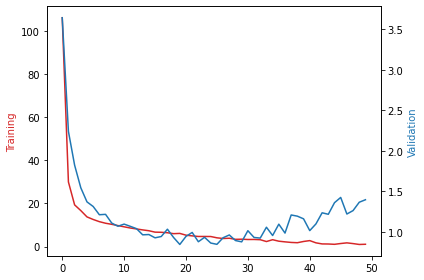

In [41]:
plot_train_val(train_history_34, valid_history_34)

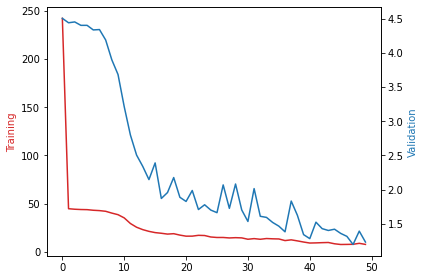

In [42]:
plot_train_val(train_history_50, valid_history_50)

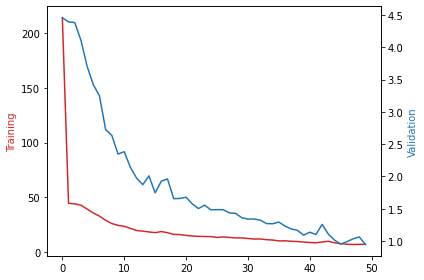

In [43]:
plot_train_val(train_history_101, valid_history_101)

As we see in the above plots, for all these three ResNets, they all have a common phenomenon: the validation loss might fluctuate or increase while minimizing the training loss. This is considered to be caused by overfitting to the training data, which can be solved by some methods practiced in our previous [deep learning courses](https://github.com/SupaeroDataScience/deep-learning/tree/main/deep), such as: Early stopping, change of the optimizer, and Dropout. Due to limited time, we will not do more experiments about overfitting here, but you can try these methods after class if you want.

Now let's take a quantitative look at the prediction accuracy of the three residual networks on the validation set.

In [44]:
# If you have saved the trained model before, then uncomment the first line
# and you can download the trained model from the `models/` folder.

# net34 = torch.load("models/resnet34")

y_valid_34, predictions_34 = get_valid_predictions(net34)

print('ResNet-34 Accuracy: ', accuracy_score(predictions_34, y_valid_34))
print(classification_report(predictions_34, y_valid_34, target_names=labels_text))

ResNet-34 Accuracy:  0.86
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.75      0.79       114
     Trouser       0.97      1.00      0.99       102
    Pullover       0.71      0.82      0.76       100
       Dress       0.86      0.89      0.88        91
        Coat       0.86      0.76      0.81       117
      Sandal       0.95      0.97      0.96        73
       Shirt       0.64      0.67      0.65       105
     Sneaker       0.97      0.89      0.93        95
         Bag       0.96      0.93      0.95       116
  Ankle boot       0.93      0.99      0.96        87

    accuracy                           0.86      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.86      0.86      0.86      1000



In [45]:
# net50 = torch.load("models/resnet50")

y_valid_50, predictions_50 = get_valid_predictions(net50)

print('ResNet-50 Accuracy: ', accuracy_score(predictions_50, y_valid_50))
print(classification_report(predictions_50, y_valid_50, target_names=labels_text))

ResNet-50 Accuracy:  0.81
              precision    recall  f1-score   support

 T-shirt/top       0.78      0.68      0.73       121
     Trouser       0.91      0.99      0.95        97
    Pullover       0.79      0.70      0.74       130
       Dress       0.79      0.83      0.81        89
        Coat       0.81      0.66      0.73       127
      Sandal       0.92      0.95      0.93        73
       Shirt       0.33      0.58      0.42        62
     Sneaker       0.98      0.88      0.92        98
         Bag       0.95      0.91      0.93       116
  Ankle boot       0.93      0.99      0.96        87

    accuracy                           0.81      1000
   macro avg       0.82      0.82      0.81      1000
weighted avg       0.83      0.81      0.82      1000



In [46]:
# net101 = torch.load("models/resnet101")

y_valid_101, predictions_101 = get_valid_predictions(net101)

print('ResNet-101 Accuracy: ', accuracy_score(predictions_101, y_valid_101))
print(classification_report(predictions_101, y_valid_101, target_names=labels_text))

ResNet-101 Accuracy:  0.841
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.72      0.78       125
     Trouser       0.94      1.00      0.97        99
    Pullover       0.74      0.83      0.78       103
       Dress       0.87      0.77      0.82       106
        Coat       0.83      0.66      0.74       130
      Sandal       0.93      0.96      0.95        73
       Shirt       0.44      0.69      0.53        70
     Sneaker       0.97      0.91      0.94        93
         Bag       0.96      0.97      0.96       110
  Ankle boot       0.97      0.98      0.97        91

    accuracy                           0.84      1000
   macro avg       0.85      0.85      0.84      1000
weighted avg       0.86      0.84      0.84      1000



The results show that all the three ResNets show good performance. In the case of 50 epochs, the prediction accuracy of all the three exceeded 80%, even close to 90%. If we further increase the number of epochs `NUM_EPOCHS`, or choose a deeper residual network structure such as ResNet-152, the result will definitely be better according to the [paper [1]](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). However, with the network depth and the number of epochs increase, the time required for model training will be longer.

### <a id="sec4-2"></a>4.2.  Test for three ResNets

We'll test the performance of the three trained residual networks ResNet-34, ResNet-50 and ResNet-101 on the test set.

In [47]:
def run_test(net):
    with torch.no_grad():
        net.eval()
        pred = []
        all_label = []
        for batch_idx, (data, label) in enumerate(testloader):
            batch_x, batch_y = data.to(device), label.to(device)
            batch_x, batch_y = Variable(batch_x), Variable(batch_y)
            output = net(batch_x)
            
            pred2 = output.max(1, keepdim=True)[1]
            pred2 = pred2.cpu().numpy()  
            for ii in range(len(pred2)):
                pred.append((pred2[ii])[0])
            all_label = np.append(all_label, batch_y.cpu().numpy())

    return pred, all_label

In [58]:
# net34 = torch.load("models/resnet34")
pred_34, y_test_34 = run_test(net34)

print('ResNet-34 Accuracy: ', accuracy_score(pred_34, y_test_34))
print(classification_report(pred_34, y_test_34, target_names=labels_text))

ResNet-34 Accuracy:  0.8531
              precision    recall  f1-score   support

 T-shirt/top       0.79      0.80      0.79       991
     Trouser       0.97      0.99      0.98       981
    Pullover       0.67      0.84      0.75       792
       Dress       0.83      0.89      0.86       930
        Coat       0.89      0.69      0.78      1285
      Sandal       0.92      0.98      0.95       940
       Shirt       0.61      0.60      0.61      1011
     Sneaker       0.99      0.87      0.92      1138
         Bag       0.96      0.96      0.96       999
  Ankle boot       0.91      0.98      0.94       933

    accuracy                           0.85     10000
   macro avg       0.85      0.86      0.85     10000
weighted avg       0.86      0.85      0.85     10000



In [59]:
# net50 = torch.load("models/resnet50")
pred_50, y_test_50 = run_test(net50)

print('ResNet-50 Accuracy: ', accuracy_score(pred_50, y_test_50))
print(classification_report(pred_50, y_test_50, target_names=labels_text))

ResNet-50 Accuracy:  0.8188
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.73      0.77      1128
     Trouser       0.92      0.99      0.95       934
    Pullover       0.83      0.63      0.72      1318
       Dress       0.80      0.85      0.82       949
        Coat       0.69      0.75      0.72       926
      Sandal       0.91      0.95      0.93       957
       Shirt       0.41      0.56      0.47       739
     Sneaker       0.96      0.84      0.90      1143
         Bag       0.94      0.95      0.95       985
  Ankle boot       0.90      0.97      0.93       921

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



In [60]:
# net101 = torch.load("models/resnet101")
pred_101, y_test_101 = run_test(net101)

print('ResNet-101 Accuracy: ', accuracy_score(pred_101, y_test_101))
print(classification_report(pred_101, y_test_101, target_names=labels_text))

ResNet-101 Accuracy:  0.832
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.72      0.78      1198
     Trouser       0.90      1.00      0.95       904
    Pullover       0.72      0.75      0.74       969
       Dress       0.86      0.79      0.82      1092
        Coat       0.76      0.72      0.74      1046
      Sandal       0.93      0.95      0.94       979
       Shirt       0.46      0.60      0.52       762
     Sneaker       0.94      0.91      0.92      1031
         Bag       0.94      0.94      0.94       999
  Ankle boot       0.96      0.94      0.95      1020

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



The results show that the test accuracy of the three ResNets has reached more than 80% even close to 90%, which is basically in line with expectations. If we use deeper networks such as ResNet-152, or increase the number of epochs `NUM_EPOCHS`, the performance of the model will be better.

# <a id="sec5"></a>5. Conclusion

ResNet has great advantages in deepening the network model and improving the accuracy of learning tasks.

$1$. Network architecture design:

- All use 3×3 convolution kernels (or most of them)
- Spatial size /2 -> filter×2 (guarantee consistent time complexity)
- No dropout layer

$2$. The experimental results show that ResNet can be trained without any difficulty, and achieve a deeper network structure to achieve lower training error and test error.

$3$. Problem analysis of the deep learning networks and some countermeasures proposed:

- Characterization ability: ResNet does not have obvious advantages in characterization ability (just repeated parameterization), but it can make the deepening network feasible.
- Easy to optimize: ResNet can make the forward/back propagation algorithm more stable (by adding Batch Normolization), greatly simplify and make it easier for the optimization of the deep networks.
- Generalization ability: ResNet does not directly consider generalization, but making the network deeper and thinner is a good generalization method.

# Sources

Here is the list of all the links and ressources of this notebook in order of appearance.

[1] [Deep Residual Learning for Image Recognition, Kaiming He et al.](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)

[2] [Learning Long-Term Dependencies with Gradient Descent is Difficult, Y. Bengio et al.](https://ieeexplore-ieee-org.rev-doc.isae.fr/stamp/stamp.jsp?tp=&arnumber=279181)

[3] [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification, Kaiming He et al.](https://arxiv.org/pdf/1502.01852.pdf)

[4] [Batch normalization: Accelerating deep network training by reducing internal covariate shift, S. Ioffe et al.](https://arxiv.org/pdf/1502.03167.pdf)

[5] [Caffe: Convolutional Architecture for Fast Feature Embedding, Y. Q. Jia et al.](https://arxiv.org/pdf/1408.5093.pdf)